# Часть 1. Проект. Методы uplift-моделирования в Яндекс Еде.

#### **Задача**

Определить целевую аудиторию, которой можно предложить промокод на 500 рублей на доставку еды из ресторанов. Цель этого предложения — побудить пользователей совершать покупки чаще. Конверсией в таком контексте можно считать успешное использование промокода, ведь тогда частота заказов увеличится, а доход компании возрастёт.

#### **Бизнес-задача**

Разработать эффективную систему, которая позволит точно идентифицировать нужную целевую аудиторию. Это повысит конверсию использования промокодов и приведёт к увеличению доходов компании.

***Цель проекта*** — создать с нуля uplift-модель на основе данных A/B-теста. Она поможет точнее выбирать клиентов, которым действительно стоит предлагать промокоды. Это не только повысит конверсию, но и улучшит финальные показатели бизнеса.

#### **Задача машинного обучения**

ML-задача — построить модель, которая наиболее точно оценивает, как предложение промокода влияет на вероятность оформления заказа у каждого пользователя.

## Этап 1. Первичная подготовка данных

Необходимо:
- импортировать необходимые библиотеки для работы с данными и визуализацией;
- загрузить датасет;
- заполнить пропуски в датасете, если они есть.

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
import mlflow
import os
from dotenv import load_dotenv

In [2]:
# загружаем данные
data = pd.read_csv("uplift_fp_data.csv")

grouped_data = (
    data.groupby("treatment")["target"].agg(["mean","count"])
)
print(data.info())
print(grouped_data)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   recency          64000 non-null  int64  
 1   history_segment  64000 non-null  int64  
 2   history          64000 non-null  float64
 3   mens             64000 non-null  int64  
 4   womens           64000 non-null  int64  
 5   zip_code         64000 non-null  int64  
 6   newbie           64000 non-null  int64  
 7   channel          64000 non-null  int64  
 8   treatment        64000 non-null  int64  
 9   target           64000 non-null  int64  
dtypes: float64(1), int64(9)
memory usage: 4.9 MB
None
               mean  count
treatment                 
0          0.144463  42613
1          0.151400  21387


In [72]:
# логирование артефактов в MLflow
load_dotenv()

REGISTERED_MODEL_NAME = os.getenv("REGISTERED_MODEL_NAME")
EXPERIMENT_NAME = os.getenv("EXPERIMENT_NAME")

AWS_ACCESS_KEY_ID = os.getenv('AWS_ACCESS_KEY_ID')
AWS_SECRET_ACCESS_KEY = os.getenv('AWS_SECRET_ACCESS_KEY')

S3_BUCKET_NAME = os.getenv('S3_BUCKET_NAME')
MLFLOW_S3_ENDPOINT_URL = os.getenv('MLFLOW_S3_ENDPOINT_URL')

TRACKING_SERVER_HOST = os.getenv("TRACKING_SERVER_HOST", "127.0.0.1")
TRACKING_SERVER_PORT = os.getenv("TRACKING_SERVER_PORT", "5000")

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

RUN_NAME = "s5_uplift_v1"
FS_ASSETS = "data/assets" 
EXPERIMENT_NAME = ""

os.makedirs(FS_ASSETS, exist_ok=True)

In [74]:
import boto3

s3 = boto3.client(
    "s3",
    endpoint_url=MLFLOW_S3_ENDPOINT_URL,
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
)

In [25]:
with open("params.yaml", "r") as f:
    params = yaml.safe_load(f)

MAX_DEPTH  = params["max_depth"]
MIN_SAMPLES_LEAF  = params["min_samples_leaf"]
TEST_SIZE   = params["test_size"]
RANDOM_STATE = params["random_state"]
N_ESTIMATORS = params["n_estimators"]
N_JOBS       = params["n_jobs"]
TOP_K       = params["top_k"]

На этапе первичной подготовки данных был загружен датасет uplift_fp_data.csv.

Проверка структуры данных показала, что:
- датасет содержит 64 000 наблюдений и 10 признаков
- пропущенные значения отсутствуют во всех столбцах
- все признаки имеют корректные числовые типы данных (int64, float64)
- переменные treatment и target являются бинарными.

Агрегация целевой переменной по группам воздействия показала различие средних значений:
- для контрольной группы (treatment = 0) среднее значение target ≈ 0.144;
- для тестовой группы (treatment = 1) среднее значение target ≈ 0.151.
- В среднем промокод увеличивает конверсию на 0.7п.п(0.151400 − 0.144463 = 0.006937) или 4.8%(0.006937 / 0.144463).

В среднем воздействие приводит к увеличению конверсии на ~0.7 п.п. Эффект невелик по величине, однако его наличие делает задачу релевантной для uplift-моделирования, целью которого является поиск сегментов пользователей с наибольшей чувствительностью к воздействию.

## Этап 2. Проведение исследовательского анализа данных

### EDA


In [4]:
# проверка размеров групп
target_sizes = data["target"].value_counts(normalize=True)
group_sizes = data["treatment"].value_counts(normalize=True)
print(target_sizes)
print(group_sizes)

# Проверка баланса групп
crosstab = pd.crosstab(data["treatment"], data["target"], normalize="index")
print(crosstab)

target
0    0.853219
1    0.146781
Name: proportion, dtype: float64
treatment
0    0.665828
1    0.334172
Name: proportion, dtype: float64
target            0         1
treatment                    
0          0.855537  0.144463
1          0.848600  0.151400


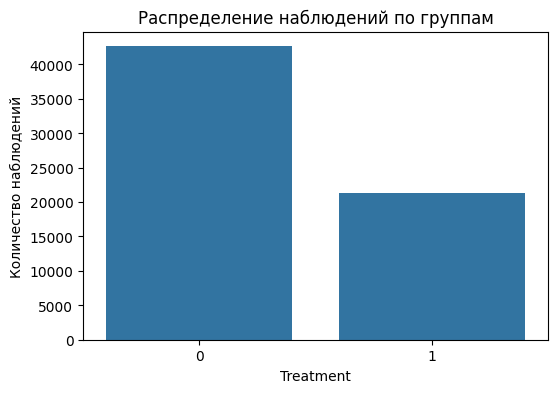

In [5]:
plt.figure(figsize=(6, 4))
sns.countplot(data=data, x="treatment")
plt.title("Распределение наблюдений по группам")
plt.xlabel("Treatment")
plt.ylabel("Количество наблюдений")
plt.show()

**Вывод по сбалансированности выборки и распределению таргета**

Выборка несбалансирована по группам воздействия: контрольная группа составляет около 66.6%, тестовая — 33.4% наблюдений. Это допустимо и типично для маркетинговых A/B-экспериментов, однако данный факт следует учитывать при дальнейшем моделировании.

Целевая переменная также несбалансирована: положительный исход наблюдается примерно в 14.7% случаев, что указывает на редкое событие.

При этом распределение таргета внутри групп воздействия сопоставимо:
- в контрольной группе конверсия составляет 14.45%,
- в тестовой — 15.14%.

Разница между группами невелика, но направлена в сторону тестовой группы, что указывает на слабый положительный эффект воздействия и подтверждает корректность постановки задачи uplift-моделирования.

### Проверка на статистическую значимость

In [6]:
# Подготовка данных

control = data[data["treatment"] == 0]["target"]
treatment = data[data["treatment"] == 1]["target"]

print("Control mean:", control.mean())
print("Treatment mean:", treatment.mean())
print("Control std:", control.std())
print("Treatment std:", treatment.std())

Control mean: 0.14446295731349587
Treatment mean: 0.151400383410483
Control std: 0.3515626711050198
Treatment std: 0.3584470880102957


Данные были разделены на две независимые группы:
- контрольная группа (treatment = 0)
- тестовая группа (treatment = 1).

Для обеих групп были рассчитаны средние значения и стандартные отклонения целевой переменной target.

**Вывод:**
Среднее значение таргета в тестовой группе (0.1514) выше, чем в контрольной (0.1445), при сопоставимых значениях стандартного отклонения. Это указывает на потенциальный положительный эффект воздействия, который требует статистической проверки.

In [7]:
# Проверка нормальности распределений (быстрая sanity-check)
from scipy.stats import shapiro

shapiro_control = shapiro(control.sample(5000, random_state=42))
shapiro_treatment = shapiro(treatment.sample(5000, random_state=42))

print("Shapiro control p-value:", shapiro_control.pvalue)
print("Shapiro treatment p-value:", shapiro_treatment.pvalue)

Shapiro control p-value: 2.089045399207799e-83
Shapiro treatment p-value: 9.42375526131186e-83


Для оценки предпосылок параметрических тестов была выполнена проверка нормальности распределения целевой переменной с помощью теста Шапиро–Уилка на случайной подвыборке.

**Результат:**

p-value для обеих групп значительно меньше 0.05, это указывает на статистически значимые различия между группами.

**Вывод:**

Проверка нормальности распределений с помощью теста Шапиро–Уилка показала, что распределения целевой переменной в контрольной и тестовой группах не являются нормальными (p-value ≪ 0.05), что ожидаемо для бинарной целевой переменной. Однако, с учётом большого объёма выборки, для сравнения средних был применён t-тест для независимых выборок, так как центральная предельная теорема обеспечивает корректность его применения.

In [8]:
# t-тест для независимых выборок

from scipy.stats import ttest_ind

t_stat, p_value = ttest_ind(
    treatment,
    control,
    equal_var=False
)

print("t-statistic:", t_stat)
print("p-value:", p_value)

t-statistic: 2.3243826621990147
p-value: 0.020109726914857923


Для проверки гипотезы о равенстве средних была использована t-проверка Стьюдента для независимых выборок с неравными дисперсиями (Welch’s t-test).

Обоснование выбора теста:
- группы независимы;
- сравниваются средние значения бинарной целевой переменной;
- дисперсии в группах могут отличаться;
- большой объём данных делает t-тест устойчивым к нарушению нормальности.

Так как p-value < 0.05, нулевая гипотеза о равенстве средних отвергается.

**Вывод:**

Различие между контрольной и тестовой группами является статистически значимым, несмотря на небольшой абсолютный эффект.

## Построение корреляций

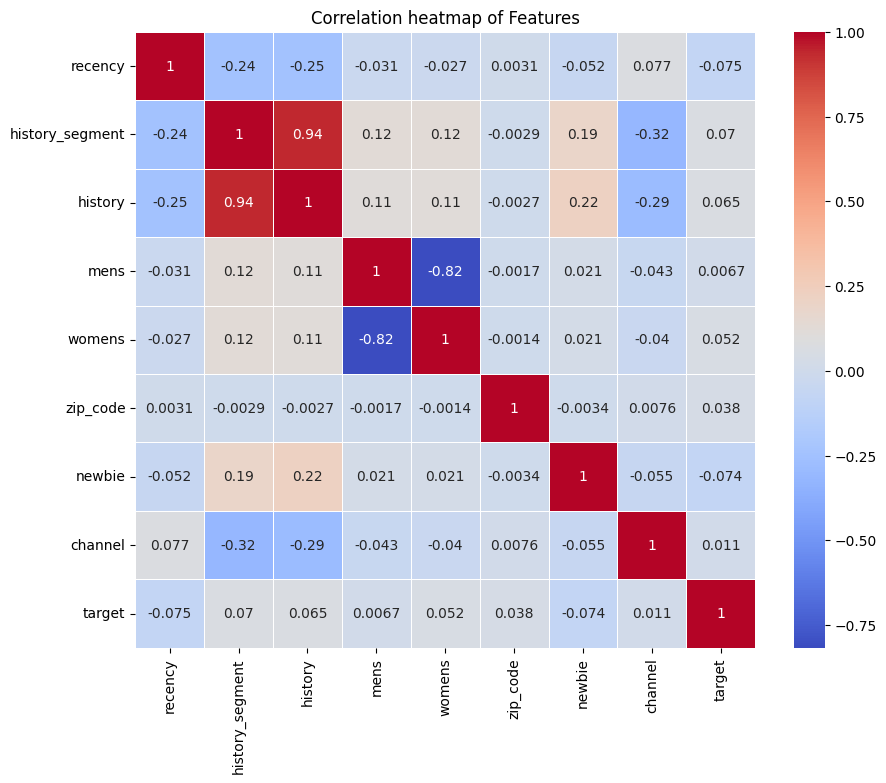

In [9]:
# Корреляционная матрица

corr_matrix = (data
                .drop(columns=['treatment'])
                .corr()
            )

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    linewidths=0.5
)
plt.title("Correlation heatmap of Features")
plt.show()

In [35]:
plt.savefig(f"{FS_ASSETS}/corr_matrix_eda.png")

<Figure size 640x480 with 0 Axes>

In [10]:
# Корреляция признаков с таргетом

target_corr = corr_matrix["target"].sort_values(ascending=False)
print(target_corr)

target             1.000000
history_segment    0.069734
history            0.065153
womens             0.051999
zip_code           0.037570
channel            0.010584
mens               0.006712
newbie            -0.073924
recency           -0.074765
Name: target, dtype: float64


**Корреляции между признаками**

- Наблюдается очень высокая положительная корреляция между признаками history_segment и history (≈ 0.94).
Это ожидаемо, так как history_segment является дискретизированным представлением суммарной истории покупок (history).
В дальнейшем это стоит учитывать как потенциальную мультиколлинеарность.
- Признаки mens и womens имеют сильную отрицательную корреляцию (≈ -0.82), что логично: пользователь, как правило, ориентирован либо на мужскую, либо на женскую категорию.
- Остальные пары признаков демонстрируют слабые или умеренные корреляции, что говорит об отсутствии сильной линейной зависимости между большинством фич.

**Корреляции признаков с целевой переменной**

- Ни один из признаков не имеет сильной линейной корреляции с таргетом.
- Признаки recency и newbie имеют слабую отрицательную корреляцию с таргетом.

Это указывает на то, что:
- поведение пользователей определяется нелинейными и комбинированными эффектами признаков
- простые линейные модели могут быть недостаточно выразительными
- использование деревьев решений, ансамблей или uplift-алгоритмов является обоснованным.

**Общий вывод корреляционного анализа:**

Корреляционный анализ показал отсутствие сильных линейных зависимостей между признаками и целевой переменной, а также выявил несколько логичных зависимостей между самими признаками (например, history и history_segment, mens и womens). Это подтверждает, что для данной задачи целесообразно использовать модели, способные улавливать сложные нелинейные взаимодействия, в том числе специализированные uplift-модели.

### **Саммари по этапу 2:**

В ходе исследовательского анализа данных было выявлено, что выборка умеренно несбалансирована по группам воздействия, однако распределение целевой переменной в контрольной и тестовой группах является сопоставимым. Проведённая статистическая проверка показала небольшой, но статистически значимый положительный эффект воздействия.

Корреляционный анализ не выявил сильных линейных зависимостей между признаками и целевой переменной, что указывает на ограниченную информативность простых линейных моделей. Это обосновывает целесообразность применения более гибких подходов, способных учитывать сложные и нелинейные взаимодействия, включая uplift-моделирование (например, RandomForest, XGBoost, uplift-деревья).

Подробнее в файле *summary_eda_p1s2.md*.

## Этап 3. Построение baseline-модели

Необходимо:

- Обосновать выбор конкретной uplift-модели для обучения.
- Разбить данные на тренировочную и тестовую выборки с учётом стратификации по воздействию и таргету в соотношени 80% на 20%.
- Обучить baseline выбранной модели, получить метрики uplift AUC, Qini AUC, Uplift@30%`.
- Важность признаков представить в виде графика, чтобы визуально отразить, какие из нх оказывают наибольшее влияние на предсказания модели.
- Обучить две любые модели из списка (S-, T-, R-, X-learner, uplift-деревья). В качестве базовых алгоритмов использовать такие же алгоритмы с одинаковыми гиперпараметрами, как и для baseline. Получить метрики для каждой модели.
- Сравнить модели с выбранным baseline и понять, почему существуют различия в метриках.
- (Опционально) Залогировать артефакты модели в MLflow вместе с метриками, важностью признаков и другими артефактами (графики, таблицы и т. д.). Убедитесь, что все артефакты имеют чёткие и понятные названия, чтобы их можно было легко идентифицировать в будущем. Для метрик используйте стандартные показатели (точность, полнота, F1-мера и AUC-ROC), чтобы оценить производительность модели.

In [11]:
# Импорты и подготовка 
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from causalml.inference.tree import UpliftRandomForestClassifier
from causalml.inference.meta import BaseSClassifier, BaseTClassifier

from itertools import product

Failed to import duecredit due to No module named 'duecredit'


In [12]:
from sklift.metrics import uplift_auc_score, qini_auc_score, uplift_at_k
from sklift.viz import plot_uplift_curve, plot_qini_curve

### Разбиение выборки на тренировочную и тестовую

In [13]:
X = data.drop(columns=["target"])
y = data["target"]

In [65]:
# Разбиение 80/20 со стратификацией по target+treatment

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    stratify=data[["target", "treatment"]],
    random_state=RANDOM_STATE
)
feature_cols = [c for c in X_train.columns if c != "treatment"]
# Важно: treatment как 0/1 для метрик (sklift ждёт 0/1)
treat_train_num = X_train["treatment"].values
treat_test_num  = X_test["treatment"].values

In [15]:
# Маппинг treatment для uplift-деревьев (causalml tree)

treatment_mapping = {0: "control", 1: "treatment"}

X_train_mapped = X_train.copy()
X_test_mapped = X_test.copy()
X_train_mapped["treatment"] = X_train_mapped["treatment"].map(treatment_mapping)
X_test_mapped["treatment"] = X_test_mapped["treatment"].map(treatment_mapping)

# Фичи без treatment (для некоторых моделей)
feature_cols = [c for c in X_train.columns if c != "treatment"]

In [47]:
# Вспомогательные функции: метрики + важность признаков

def compute_metrics(y_true, uplift_pred, treatment, k=0.30):
    uplift_pred = np.asarray(uplift_pred).squeeze()
    treatment = np.asarray(treatment).squeeze()

    auuc = uplift_auc_score(y_true=y_true, uplift=uplift_pred, treatment=treatment)
    qini = qini_auc_score(y_true=y_true, uplift=uplift_pred, treatment=treatment)
    u_at_k = uplift_at_k(y_true=y_true, uplift=uplift_pred, treatment=treatment, strategy="overall", k=k)

    return auuc, qini, u_at_k

def plot_curves(method_type, y_true, uplift_pred, treatment, title_prefix):
    uplift_pred = np.asarray(uplift_pred).squeeze()
    treatment = np.asarray(treatment).squeeze()

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    plot_uplift_curve(y_true, uplift_pred, treatment, perfect=True, ax=ax, name=f"{title_prefix} Uplift curve")
    ax.set_title(f"{title_prefix}: Uplift curve")
    plt.savefig(f"{FS_ASSETS}/{method_type}_uplift_curve.png")
    plt.show()

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    plot_qini_curve(y_true, uplift_pred, treatment, perfect=True, ax=ax, name=f"{title_prefix} Qini curve")
    ax.set_title(f"{title_prefix}: Qini curve")
    plt.savefig(f"{FS_ASSETS}/{method_type}_qini_curve.png")
    plt.show()

def plot_feature_importances(method_type, importances, feature_names, title):
    fi = pd.Series(importances, index=feature_names).sort_values(ascending=True)
    plt.figure(figsize=(10, 7))
    plt.barh(fi.index, fi.values)
    plt.title(title)
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.savefig(f"{FS_ASSETS}/{method_type}_feature_importances.png")
    plt.show()

В качестве baseline была выбрана модель UpliftRandomForestClassifier, поскольку:

- она напрямую оптимизирована под задачу uplift-моделирования, а не является обёрткой над классическими классификаторами;
- модель не требует обучения отдельных моделей для контрольной и тестовой групп, что упрощает интерпретацию и снижает риск ошибок;
- Random Forest хорошо работает с нелинейными зависимостями и взаимодействиями признаков, которые были выявлены на этапе EDA (низкие линейные корреляции с таргетом);
- модель устойчива к шуму и не требует строгих предпосылок о распределениях данных.

Таким образом, UpliftRandomForestClassifier был выбран как простой, интерпретируемый и устойчивый baseline, относительно которого целесообразно сравнивать более сложные подходы (S-, T-, R-, X-learners).

### Обучение выбранного бейзлайна

In [26]:
# Baseline: UpliftRandomForestClassifier (uplift-деревья)
# Гиперпараметры (их потом используем и для S/T, чтобы было честно)

baseline = UpliftRandomForestClassifier(
    control_name="control",
    n_estimators=N_ESTIMATORS,
    max_depth=MAX_DEPTH,
    min_samples_leaf=MIN_SAMPLES_LEAF,
    random_state=RANDOM_STATE
)

baseline.fit(
    X_train_mapped[feature_cols].values,
    treatment=X_train_mapped["treatment"].values,
    y=y_train.values
)

### Расчет метрик для выбранного бейзлайна на тестовой выборке

=== BASELINE: UpliftRandomForestClassifier ===
Uplift AUC (AUUC): 0.0289
Qini AUC:         0.0652
Uplift@30%:       0.0465


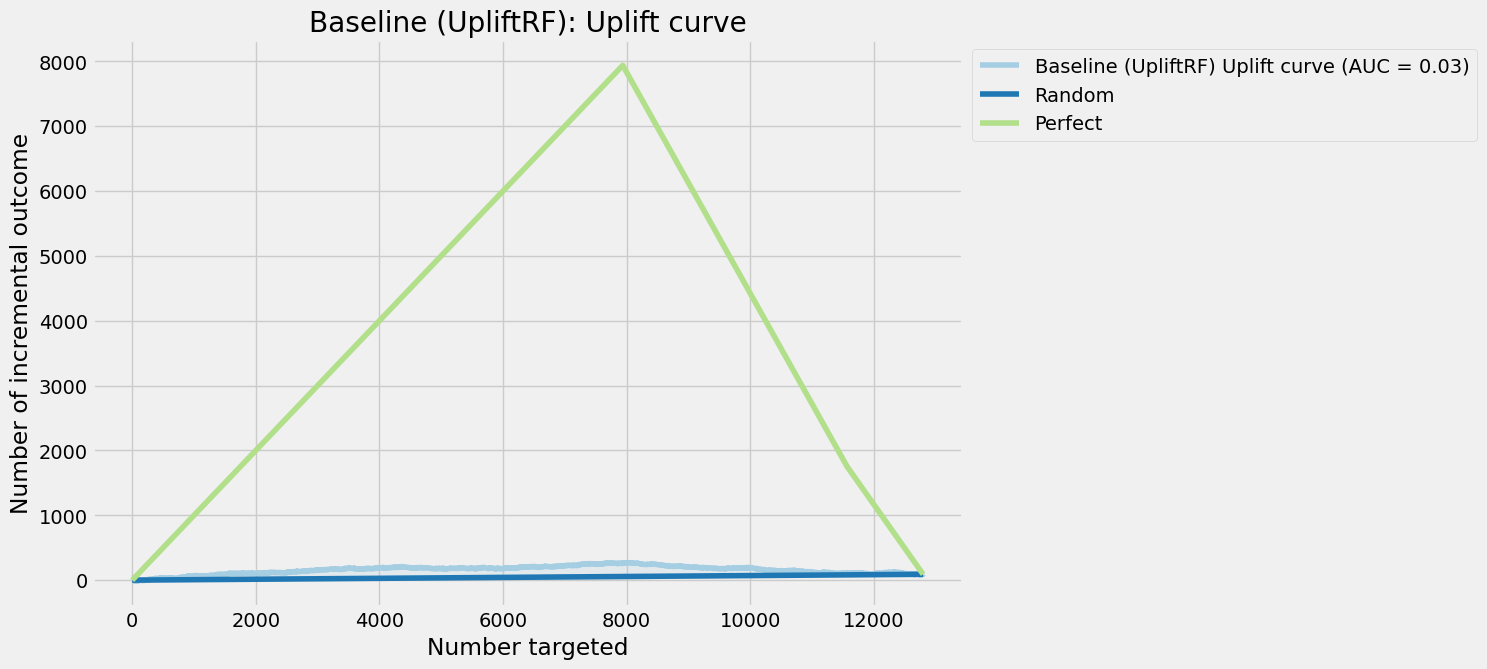

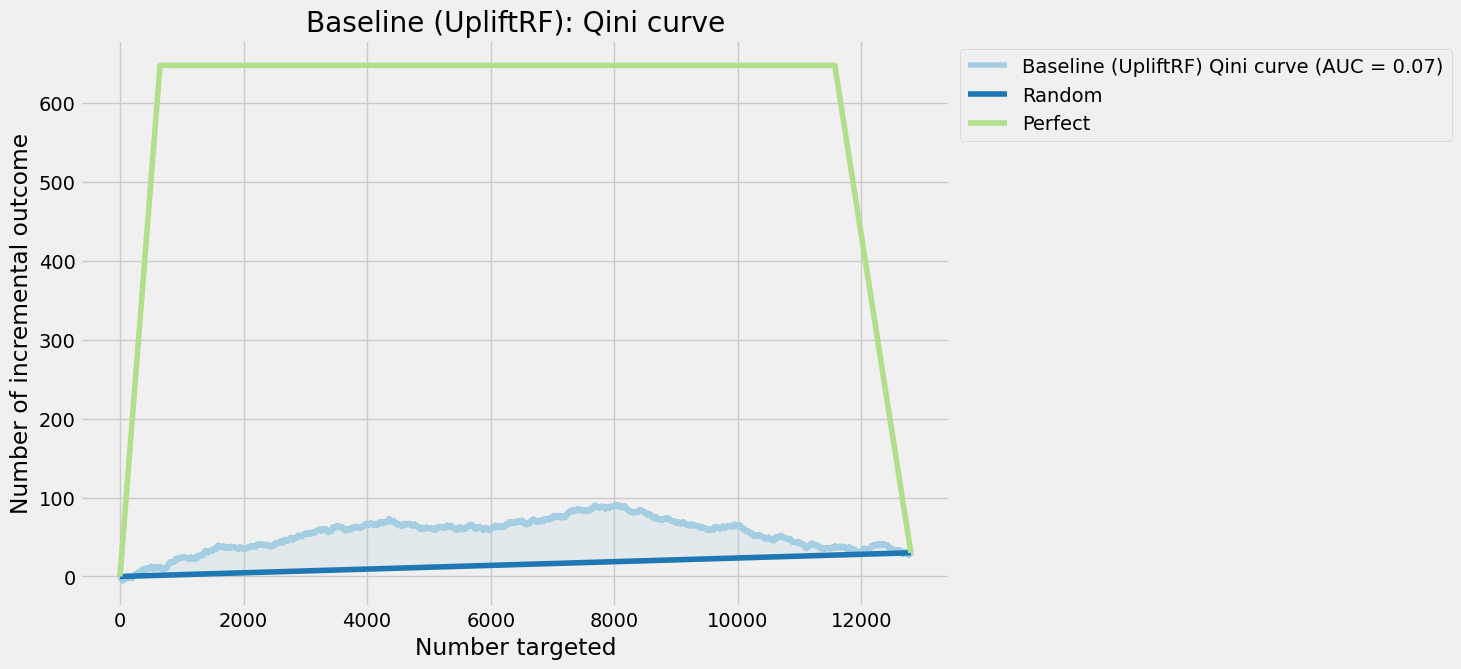

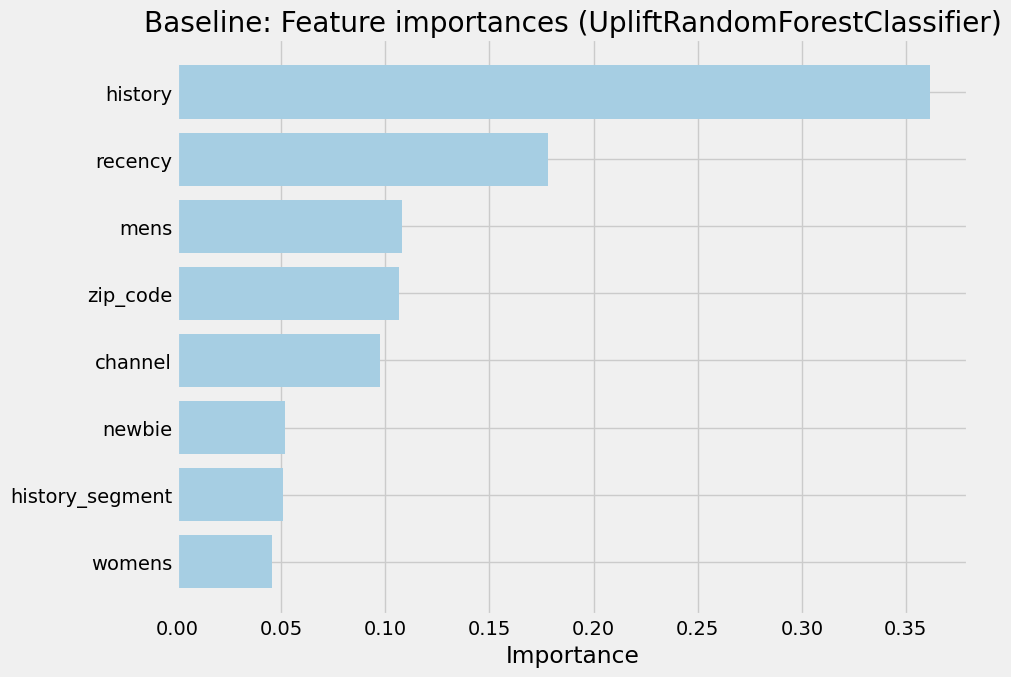

In [38]:
uplift_pred_baseline = baseline.predict(
    X_test_mapped[feature_cols].values,
    full_output=False
).squeeze()

auuc_b, qini_b, u30_b = compute_metrics(
    y_true=y_test.values,
    uplift_pred=uplift_pred_baseline,
    treatment=treat_test_num,
    k=TOP_K
)

print("=== BASELINE: UpliftRandomForestClassifier ===")
print(f"Uplift AUC (AUUC): {auuc_b:.4f}")
print(f"Qini AUC:         {qini_b:.4f}")
print(f"Uplift@30%:       {u30_b:.4f}")

plot_curves("baseline_v1", y_test.values, uplift_pred_baseline, treat_test_num, "Baseline (UpliftRF)")

# Feature importances (если доступны)
if hasattr(baseline, "feature_importances_"):
    plot_feature_importances(
        "baseline_v1", 
        baseline.feature_importances_,
        feature_cols,
        "Baseline: Feature importances (UpliftRandomForestClassifier)"
    )
else:
    print("У baseline нет feature_importances_ (зависит от версии causalml).")

Baseline-модель на основе UpliftRandomForestClassifier показала положительное, но слабое качество предсказаний uplift-эффекта:
- Uplift AUC (AUUC) = 0.03,
- Qini AUC = 0.07,
- Uplift@30% = 0.046.

Форма uplift- и Qini-кривых находится выше случайной линии, что указывает на наличие полезного сигнала, однако величина эффекта невелика. Это согласуется с результатами EDA, где был выявлен небольшой средний эффект воздействия (~0.7 п.п.).
Baseline-модель корректно захватывает часть гетерогенности отклика, но оставляет значительный потенциал для улучшения с помощью более гибких uplift-подходов.

Дополнительно анализ важности признаков показал, что наибольший вклад в предсказание uplift-эффекта вносят признаки history и recency, что логично с точки зрения бизнеса: история и давность покупок сильнее всего определяют реакцию клиента на маркетинговое воздействие.

# Обучение 2 моделей 

### Модель 1: S-learner (BaseSClassifier) на RandomForestClassifier

In [69]:
rf_base = RandomForestClassifier(
    n_estimators=N_ESTIMATORS,
    max_depth=MAX_DEPTH,
    min_samples_leaf=MIN_SAMPLES_LEAF,
    random_state=RANDOM_STATE,
    n_jobs=N_JOBS
)

s_learner = BaseSClassifier(
    learner=rf_base,
    control_name=0
)

# BaseSClassifier сам учитывает treatment как фичу, поэтому даём X_train целиком (включая treatment)
s_learner.fit(
    X=X_train.values,
    treatment=X_train["treatment"].values,
    y=y_train.values
)

# получаем предсказания uplift для тестовой выборки
uplift_pred_s = s_learner.predict(X_test.values).squeeze()

### Получение метрик по модели 1


=== MODEL 1: S-learner (BaseSClassifier + RF) ===
Uplift AUC (AUUC): 0.0295
Qini AUC:         0.0660
Uplift@30%:       0.0360


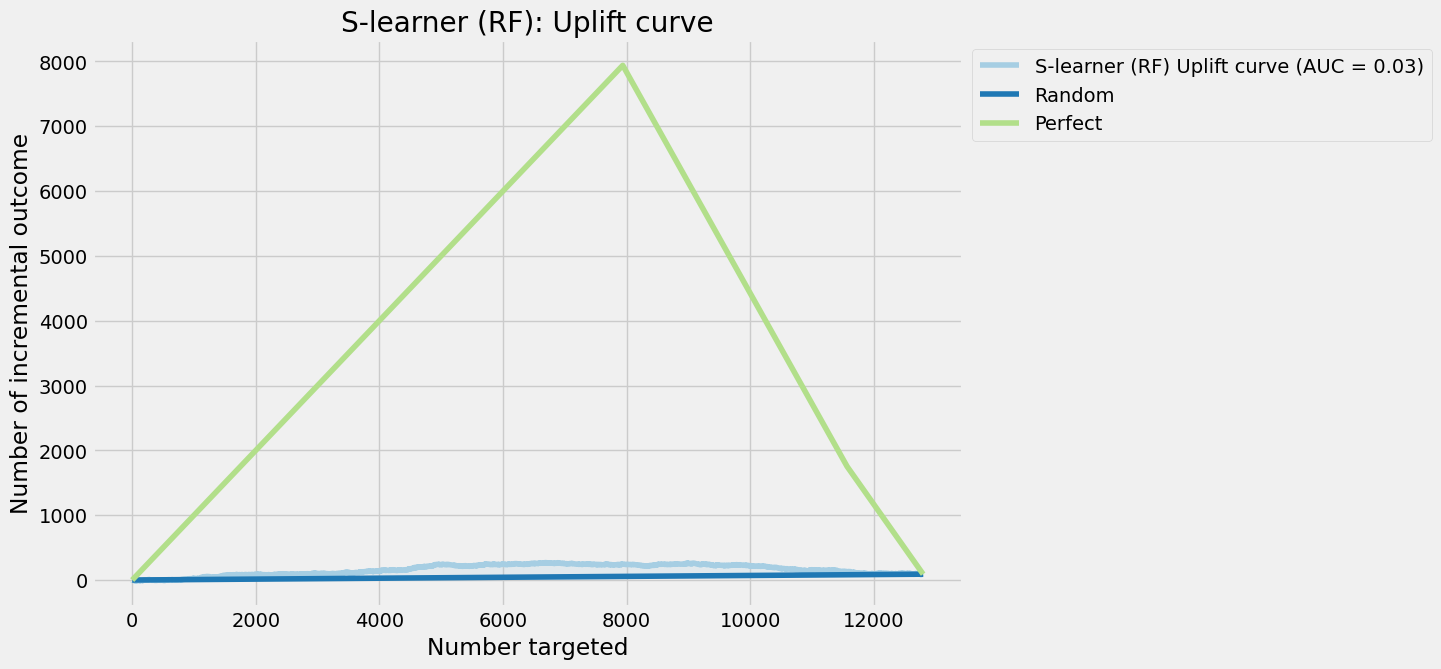

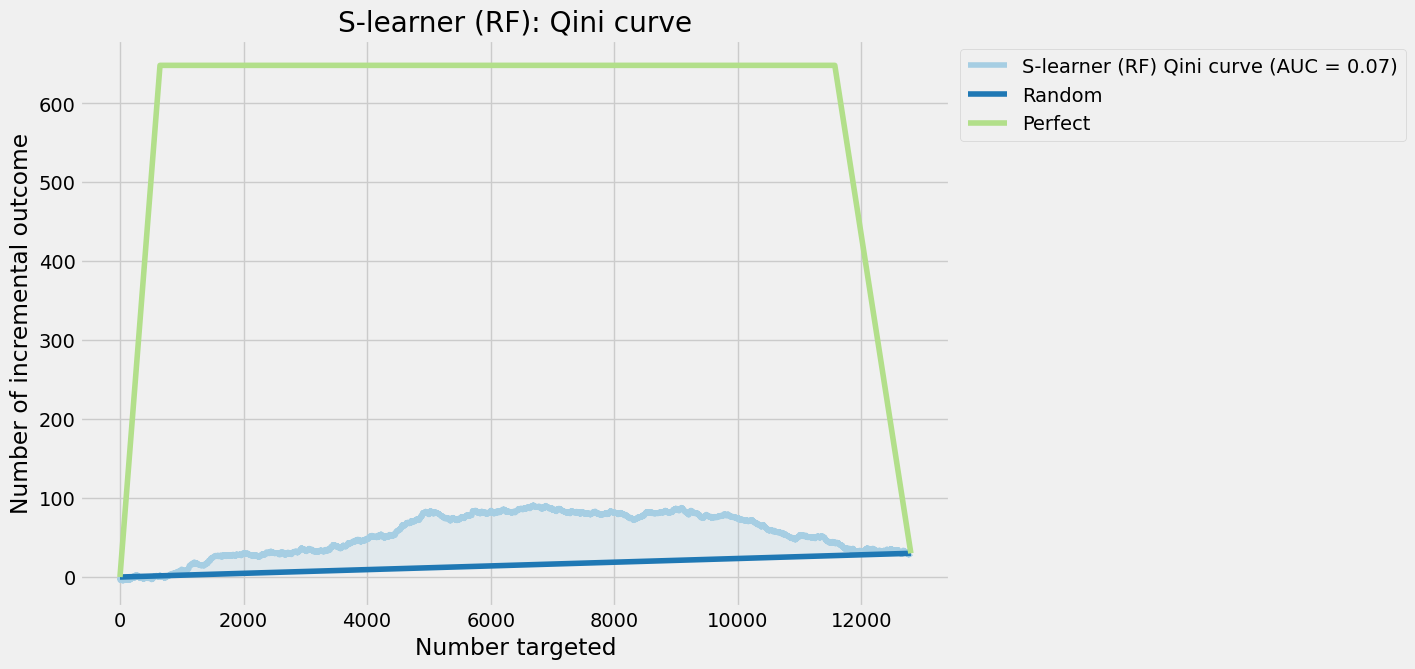

In [41]:
auuc_s, qini_s, u30_s = compute_metrics(
    y_true=y_test.values,
    uplift_pred=uplift_pred_s,
    treatment=treat_test_num,
    k=TOP_K
)

print("\n=== MODEL 1: S-learner (BaseSClassifier + RF) ===")
print(f"Uplift AUC (AUUC): {auuc_s:.4f}")
print(f"Qini AUC:         {qini_s:.4f}")
print(f"Uplift@30%:       {u30_s:.4f}")

plot_curves("s_learner_rfc_v1", y_test.values, uplift_pred_s, treat_test_num, "S-learner (RF)")

# Feature importances для RF (если есть)
if hasattr(rf_base, "feature_importances_"):
    plot_feature_importances(
        "s_learner_rfc_v1", 
        rf_base.feature_importances_,
        X_train.columns.tolist(),  # включая treatment
        "S-learner: Feature importances (RandomForestClassifier)"
    )

### Модель 2: T-learner (BaseTClassifier) на RandomForestClassifier

In [42]:
rf_treat = RandomForestClassifier(
    n_estimators=N_ESTIMATORS,
    max_depth=MAX_DEPTH,
    min_samples_leaf=MIN_SAMPLES_LEAF,
    random_state=RANDOM_STATE,
    n_jobs=N_JOBS
)

rf_ctrl = RandomForestClassifier(
    n_estimators=N_ESTIMATORS,
    max_depth=MAX_DEPTH,
    min_samples_leaf=MIN_SAMPLES_LEAF,
    random_state=RANDOM_STATE,
    n_jobs=N_JOBS
)

t_learner = BaseTClassifier(
    treatment_learner=rf_treat,
    control_learner=rf_ctrl,
    control_name=0
)

t_learner.fit(
    X=X_train.values,
    treatment=X_train["treatment"].values,
    y=y_train.values
)

uplift_pred_t = t_learner.predict(X_test.values).squeeze()


### Получение метрик по модели 2


=== MODEL 2: T-learner (BaseTClassifier + RF/RF) ===
Uplift AUC (AUUC): 0.0279
Qini AUC:         0.0630
Uplift@30%:       0.0368


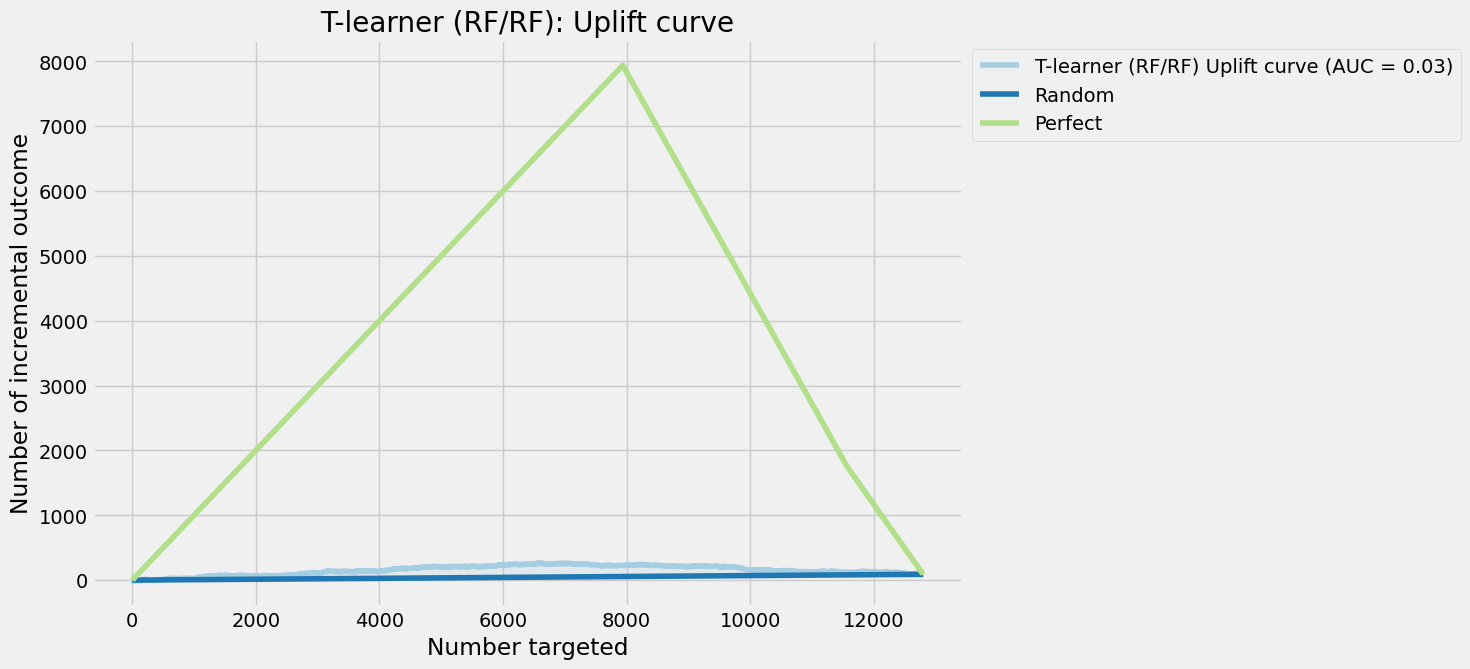

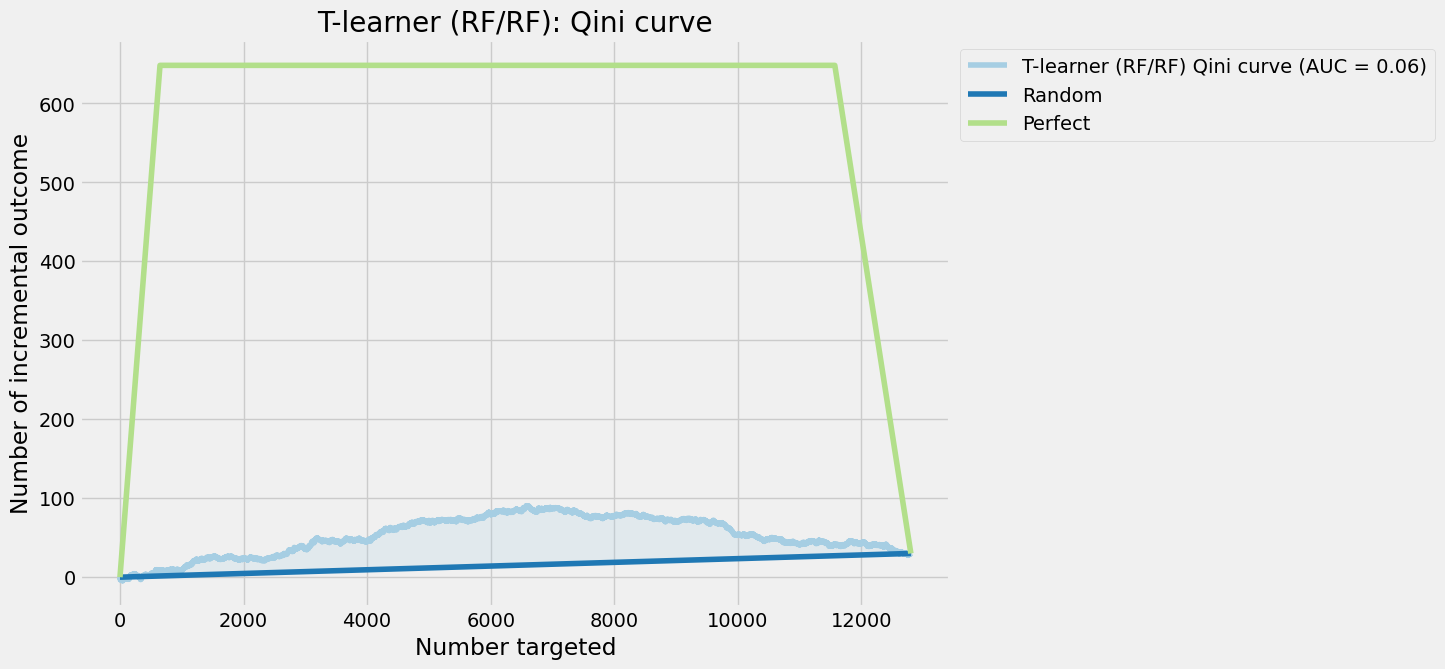

In [43]:
auuc_t, qini_t, u30_t = compute_metrics(
    y_true=y_test.values,
    uplift_pred=uplift_pred_t,
    treatment=treat_test_num,
    k=TOP_K
)

print("\n=== MODEL 2: T-learner (BaseTClassifier + RF/RF) ===")
print(f"Uplift AUC (AUUC): {auuc_t:.4f}")
print(f"Qini AUC:         {qini_t:.4f}")
print(f"Uplift@30%:       {u30_t:.4f}")

plot_curves("t_learner_rfc_v1", y_test.values, uplift_pred_t, treat_test_num, "T-learner (RF/RF)")

In [45]:
# Сводная табличка
results = pd.DataFrame([
    {"model": "Baseline UpliftRF", "AUUC": auuc_b, "QiniAUC": qini_b, "Uplift@30%": u30_b},
    {"model": "S-learner (RF)",    "AUUC": auuc_s, "QiniAUC": qini_s, "Uplift@30%": u30_s},
    {"model": "T-learner (RF/RF)", "AUUC": auuc_t, "QiniAUC": qini_t, "Uplift@30%": u30_t},
]).sort_values(by="QiniAUC", ascending=False)

print("\n=== SUMMARY ===")
display(results)


=== SUMMARY ===


,model,AUUC,QiniAUC,Uplift@30%
1,S-learner (RF),0.029536,0.066017,0.036015
0,Baseline UpliftRF,0.028866,0.065151,0.046537
2,T-learner (RF/RF),0.027921,0.063026,0.036805


In [46]:
results.to_csv('data/baseline_uplift_summary.csv')

In [ ]:
from sklearn.metrics import (
    roc_auc_score, precision_score, recall_score, f1_score
)

# helpers
def safe_float(x):
    try:
        x = float(x)
        return x if np.isfinite(x) else None
    except Exception:
        return None

def log_binary_metrics(prefix: str, y_true: np.ndarray, y_score: np.ndarray, thr: float = 0.5):
    """
    y_score: вероятность/скор (0..1) или любой монотонный скор.
    """
    y_true = np.asarray(y_true).astype(int)
    y_score = np.asarray(y_score).astype(float)

    y_pred = (y_score >= thr).astype(int)

    metrics = {
        f"{prefix}_auc_roc": safe_float(roc_auc_score(y_true, y_score)),
        f"{prefix}_precision": safe_float(precision_score(y_true, y_pred, zero_division=0)),
        f"{prefix}_recall": safe_float(recall_score(y_true, y_pred, zero_division=0)),
        f"{prefix}_f1": safe_float(f1_score(y_true, y_pred, zero_division=0)),
    }
    print("-- Metrics --\n", metrics)
    mlflow.log_metrics({k: v for k, v in metrics.items() if v is not None})
    return metrics

def sigmoid(x):
    x = np.asarray(x, dtype=float)
    return 1 / (1 + np.exp(-x))


In [58]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.validation import check_is_fitted

def safe_float(x):
    try:
        return float(x)
    except Exception:
        return None


def compute_binary_metrics(y_true, proba):
    """Стандартные метрики для обычного классификатора (где есть вероятность)."""
    y_true = np.asarray(y_true)
    proba = np.asarray(proba)

    # порог 0.5 для метрик классификации
    y_pred = (proba >= 0.5).astype(int)

    return {
        "roc_auc": safe_float(roc_auc_score(y_true, proba)),
        "accuracy": safe_float(accuracy_score(y_true, y_pred)),
        "precision": safe_float(precision_score(y_true, y_pred, zero_division=0)),
        "recall": safe_float(recall_score(y_true, y_pred, zero_division=0)),
        "f1": safe_float(f1_score(y_true, y_pred, zero_division=0)),
    }

# 1) Достаём sklearn-модель из BaseSClassifier максимально безопасно
def get_fitted_slearner_model(s_learner):
    candidates = [
        getattr(s_learner, "model", None),
        getattr(s_learner, "learner", None),
        getattr(s_learner, "models", None),  # иногда causalml хранит тут
    ]
    # models может быть списком/словарём
    flat = []
    for c in candidates:
        if c is None:
            continue
        if isinstance(c, (list, tuple)):
            flat.extend(c)
        elif isinstance(c, dict):
            flat.extend(c.values())
        else:
            flat.append(c)

    for m in flat:
        if m is None:
            continue
        if hasattr(m, "predict_proba"):
            try:
                check_is_fitted(m)
                return m
            except Exception:
                pass
    return None

s_base = get_fitted_slearner_model(s_learner)

if s_base is None:
    raise RuntimeError("Не нашла обученную sklearn-модель внутри s_learner.")

In [77]:
import os
import pickle
import numpy as np
import pandas as pd
import mlflow
import mlflow.sklearn

from mlflow.models.signature import infer_signature

ARTIFACTS_DIR = "data"
EXPERIMENT_NAME="yandex_eats_uplift"

# 2) Эксперимент и запуск
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if not experiment:
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
else:
    experiment_id = experiment.experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    print("MLflow run_id:", run.info.run_id)

    # --- params ---
    mlflow.log_params({
        "stage": "3_baseline_and_models",
        "random_state": int(RANDOM_STATE),
        "test_size": float(TEST_SIZE),
        "top_k": float(TOP_K),
        "uplift_max_depth": int(MAX_DEPTH),
        "uplift_n_estimators": int(N_ESTIMATORS),
        "uplift_min_samples_leaf": int(MIN_SAMPLES_LEAF),
        "base_learner": "RandomForestClassifier",
        "n_jobs": int(N_JOBS),
    })

    # --- uplift metrics (основное) ---
    uplift_metrics = {
        "baseline_auuc": safe_float(auuc_b),
        "baseline_qini_auc": safe_float(qini_b),
        "baseline_uplift_at_30": safe_float(u30_b),

        "slearner_auuc": safe_float(auuc_s),
        "slearner_qini_auc": safe_float(qini_s),
        "slearner_uplift_at_30": safe_float(u30_s),

        "tlearner_auuc": safe_float(auuc_t),
        "tlearner_qini_auc": safe_float(qini_t),
        "tlearner_uplift_at_30": safe_float(u30_t),
    }
    mlflow.log_metrics({k: v for k, v in uplift_metrics.items() if v is not None})

    # --- standard metrics (ТОЛЬКО outcome-модель RF из S-learner) ---
    # Важно: X_train/X_test содержат колонку treatment, и S-learner учился на X_train.values

    # X_test: DataFrame, в нём уже есть treatment (0/1)
    X_mat = X_test.values
    treat_col = X_test["treatment"].values.reshape(-1, 1)

    X_test_s_10 = np.hstack([X_mat, treat_col])  # 10 фич, как при fit у BaseSClassifier

    s_proba = s_base.predict_proba(X_test_s_10)[:, 1]

    std_metrics = compute_binary_metrics(y_test.values, s_proba)
    print("-- Metrics --\n", std_metrics)
    mlflow.log_metrics({f"slearner_outcome_{k}": v for k, v in std_metrics.items() if v is not None})

    # --- сводная таблица как артефакт ---
    summary = pd.DataFrame([{
        **uplift_metrics,
        **{f"slearner_outcome_{k}": v for k, v in std_metrics.items() if v is not None},
    }])
    os.makedirs(ARTIFACTS_DIR, exist_ok=True)
    summary_path = os.path.join(ARTIFACTS_DIR, "mlflow_stage3_summary.csv")
    summary.to_csv(summary_path, index=False)
    mlflow.log_artifact(summary_path, artifact_path="metrics")

    # --- артефакты из data/ (графики uplift/qini/важности/таблички) ---
    if os.path.isdir(ARTIFACTS_DIR):
        mlflow.log_artifacts(ARTIFACTS_DIR, artifact_path="data")

    # --- логируем sklearn RF из S-learner как модель ---
    # делаем sample с тем же 10-фичевым форматом
    X_sig_df = X_test.head(50)
    X_sig_10 = np.hstack([X_sig_df.values, X_sig_df["treatment"].values.reshape(-1, 1)])

    y_sig = s_base.predict_proba(X_sig_10)[:, 1]
    signature = infer_signature(X_sig_10, y_sig)

    mlflow.sklearn.log_model(
        sk_model=s_base,
        artifact_path="models/s_learner_rf",
        registered_model_name=f"{REGISTERED_MODEL_NAME}_slearner_rf",
        signature=signature,
        input_example=X_sig_10[:5],
    )

        # ---- log notebook ----
    notebook_path = "final_project_template.ipynb"
    if os.path.exists(notebook_path):
        mlflow.log_artifact(notebook_path, artifact_path="notebooks")

    # --- uplift-модели как pickle (baseline/s/t) ---
    for name, model in [
        ("baseline_uplift_rf", baseline),
        ("s_learner_causalml", s_learner),
        ("t_learner_causalml", t_learner),
    ]:
        pkl_path = os.path.join(ARTIFACTS_DIR, f"{name}.pkl")
        with open(pkl_path, "wb") as f:
            pickle.dump(model, f)
        mlflow.log_artifact(pkl_path, artifact_path="models/pickles")

print("✅ Logged to MLflow (simple).")

MLflow run_id: 5aad8fee98f94a6eabe3a64bd043d5a0
-- Metrics --
 {'roc_auc': 0.4974074049347291, 'accuracy': 0.853203125, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}


Registered model 'yandex_eats_uplift_model_slearner_rf' already exists. Creating a new version of this model...
2025/12/21 10:08:22 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: yandex_eats_uplift_model_slearner_rf, version 2
Created version '2' of model 'yandex_eats_uplift_model_slearner_rf'.


✅ Logged to MLflow (simple).


Outcome-модель S-learner показывает качество, близкое к случайному угадыванию (ROC-AUC ≈ 0.5), что связано с низкой предсказуемостью таргета и дисбалансом классов. Это ожидаемо для uplift-задачи и не является критичным, так как основная цель модели — корректное ранжирование пользователей по uplift-эффекту, которое оценивается метриками AUUC, Qini AUC и Uplift@K.

Артефакты и модели залогированы в MLFlow.

### **Саммари по этапу 3:**

В рамках данного этапа были обучены и сравнены три uplift-модели: baseline-модель на основе UpliftRandomForestClassifier, а также модели S-learner и T-learner, использующие одинаковые базовые алгоритмы и гиперпараметры. Для всех моделей была применена стратифицированная схема разбиения данных на тренировочную и тестовую выборки в соотношении 80/20.

Полученные значения метрик AUUC и Qini AUC оказались близкими для всех моделей и лишь незначительно превосходят уровень случайного ранжирования, что указывает на слабую гетерогенность uplift-эффекта в исходных данных. Это согласуется с результатами EDA, где был выявлен небольшой средний эффект воздействия и отсутствие сильных линейных зависимостей между признаками и таргетом.

Несмотря на схожие значения интегральных метрик, baseline-модель на uplift-деревьях продемонстрировала наилучший результат по метрике Uplift@30%, что делает её наиболее предпочтительной с точки зрения практического применения, ориентированного на таргетирование наиболее перспективных клиентов.

Анализ важности признаков показал, что наибольший вклад в предсказания модели вносят поведенческие характеристики пользователей, такие как history и recency, что является интуитивно ожидаемым и подтверждает корректность работы модели.

В целом, различия между моделями обусловлены особенностями их архитектуры и тем, как они обрабатывают слабый uplift-сигнал: S- и T-learner подходы более чувствительны к шуму, тогда как uplift-деревья оптимизируют разбиения напрямую под эффект воздействия. Для дальнейшего улучшения качества моделей целесообразно рассмотреть более сложные методы, такие как R-learner или X-learner, которые лучше подходят для задач со слабым и потенциально смещённым эффектом.

# Часть 2

## Этап 1
Улучшите бейзлайн выбранной модели

#### Генерация признаков (опционально)

### Подбор гиперпараметров

In [ ]:
from optuna import create_study
from sklift.metrics import uplift_at_k

def objective(trial):
    # Дополните код для подбора гиперпараметров

    uplift_at_30 = uplift_at_k(y_test, uplift_pred, treatment_test, k=0.3, strategy='overall')
    return uplift_at_30

# Создаем и запускаем исследование
study = create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Выводим лучшие гиперпараметры
print("Best hyperparameters: ", study.best_params)
print("Best score: ", study.best_value)


## Этап 2

### Визуализация результатов

In [ ]:
from utils import custom_uplift_by_percentile

В данной ячейке сделайте вывод о качестве работы модели и проинтерпретируйте график `uplift by percentile` 

# Этап 3

In [ ]:
# Класс для инференса модели
class UpliftModelInference:
    """
    Класс для инференса uplift модели.
    """
    
    def __init__(self, model, feature_names, logger=None):
        """
        Инициализация класса.
        
        Аргументы:
            model: Обученная модель uplift
            feature_names: Список признаков для предсказания 
            logger: Объект для логирования (по умолчанию None)
        """
        self.model = model
        self.feature_names = ['recency', 'history_segment', 'history', 'mens', 'womens', 'zip_code', 'newbie', 'channel']
        self.logger = logger
        
        if self.logger:
            self.logger.info("Модель UpliftModel инициализирована с признаками: %s", feature_names)

    def _transform_data(self, X):
        """
        Преобразование данных для модели.
        
        Аргументы:
            X: pandas.DataFrame с признаками
        """
        if self.logger:
            self.logger.debug("Преобразование входных данных размерности %s", X.shape)

        # реализуйте преобразование данных для модели,
        # если в финальной модели используются новые признаки
       

        return X
    
    def predict(self, X):
        """
        Получение предсказаний uplift.
        
        Аргументы:
            X: pandas.DataFrame с признаками
            
        Возвращает:
            numpy.array с предсказанными значениями uplift
        """
        # Проверяем, что датафрейм не пустой
        if X.empty:
            if self.logger:
                self.logger.error("Предоставлен пустой датафрейм")
            return None
            
        # Проверяем наличие пропущенных значений
        if X.isnull().any().any():
            if self.logger:
                self.logger.error("Входные данные содержат пропущенные значения")
            return [None]*len(X)
        
        if self.logger:
            self.logger.info("Выполняем предсказания для данных размерности %s", X.shape)

        # Проверяем наличие всех необходимых признаков
        missing_features = set(self.feature_names) - set(X.columns)
        if missing_features:
            error_msg = f"Отсутствуют признаки: {missing_features}"
            if self.logger:
                self.logger.error(error_msg)

            return [None]*len(X)
        
        # Преобразуем данные для модели
        if self.logger:
            self.logger.debug("Начинаем преобразование данных")
        X = self._transform_data(X)
        
        # Вычисляем uplift
        if self.logger:
            self.logger.debug("Выполняем предсказания модели")
        

        # Дополните код для получения предсказаний аплифта

        
        if self.logger:
            self.logger.info("Предсказания успешно завершены")
            
        return uplift


In [ ]:
model = UpliftModelInference(model= # ваш код,
                             feature_names= # ваш код)

In [ ]:
test_data = pd.DataFrame({
            'recency': [1, 2, 3],
            'history_segment': [1, 2, 3], 
            'history': [100, 200, 300],
            'mens': [1, 0, 1],
            'womens': [0, 1, 0],
            'zip_code': [1, 0, 1],
            'newbie': [0, 1, 0],
            'channel': [1, 2, 0]
        })

In [ ]:
# проверка работы класса
model.predict(test_data)